## Key Facts of Malaria
- Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.
- In 2017, there were an estimated **219 million** cases of malaria in **87 countries**.
- The estimated number of malaria deaths stood at **435 000** in 2017.
- The WHO African Region carries a disproportionately high share of the global malaria burden. In 2017, the region was home to **92%** of malaria cases and **93%** of malaria deaths.
- Total funding for malaria control and elimination reached an estimated **US dollar 3.1billion** 

Malaria is caused by **Plasmodium parasites.** The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called **"malaria vectors.**" There are 5 parasite species that cause malaria in humans, and 2 of these species – **P. falciparum** and **P. vivax** – pose the greatest threat.
[source](https://www.who.int/news-room/fact-sheets/detail/malaria)

![](https://i.ibb.co/QdQPJkY/malar1.jpg)
source: **thegreatcoursesdaily.com**

In this kernel, I have shown the stepwise process of creating Convolution Neural Network Model using keras library for classifying images of Normal and Malaria parasite infected human blood sample. 

Apart from that, I have also deployed a flask based web app. The link for **LIVE WEB APP** : [Malaria Detection Web App ](https://malaria-detection-app.herokuapp.com/).Github repo :[malaria_detector](https://github.com/sid321axn/malaria-detection-app)   .Below is the snapshot of the web app deployed over internet.
![](https://i.ibb.co/gM7qfp4/malaria.png)

## Stepwise Approach
Following steps have been followed while building the CNN based model
1. [Step 1 : Importing Essential Libraries](#step-1)
2. [Step 2 : Loading data](#step-2)
3. [Step 3: EDA -> Checking sample of Infected and Uninfected images](#step-3)
4. [Step 4: Data Preprocessing (Labeling & Resizing of images)](#step-4)
5. [Step 5: Train Test Split](#step-5)
6. [Step 6: Normalization](#step-6)
7. [Step 7: Label Encoding](#step-7)
8. [Step 8 : Model Building: CNN](#step-8)
9. [Step 9: Compiling the model](#step-9)
10. [Step 10: Setting Callbacks](#step-10)
11. [Step 11: Model Fitting](#step-11)
12. [Step 12: Model Evaluation (Testing accuracy, confusion matrix, classification report)](#step-12)
13. [Step 13: Plotting ROC-AUC Curve](#step-13)
14. [Step 14: Plotting Sample Prediction (Groundtruth vs Prediction)](#step-14)
15. [Conclusion & Future Improvements](#conc-fut)


## Step 1: Importing Essential Libraries<a id='step-1'></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_curve,auc,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
from PIL import Image
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random
import os
print(os.listdir("cell_images"))


['Parasitized', 'Uninfected']


## Step 2: Loading Data<a id='step-2'></a>
In this step we will first create separate directory to store Parasitized and Normal images (Uninfected)

In [2]:
# setting path of directory
PARA_DIR = "cell_images/Parasitized/"
NORM_DIR =  "cell_images/Uninfected/"

# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(NORM_DIR)

## Step 3: EDA -> Checking sample images<a id='step-3'></a>
In this step we will check the actual sample images of both infected and normal blood sample

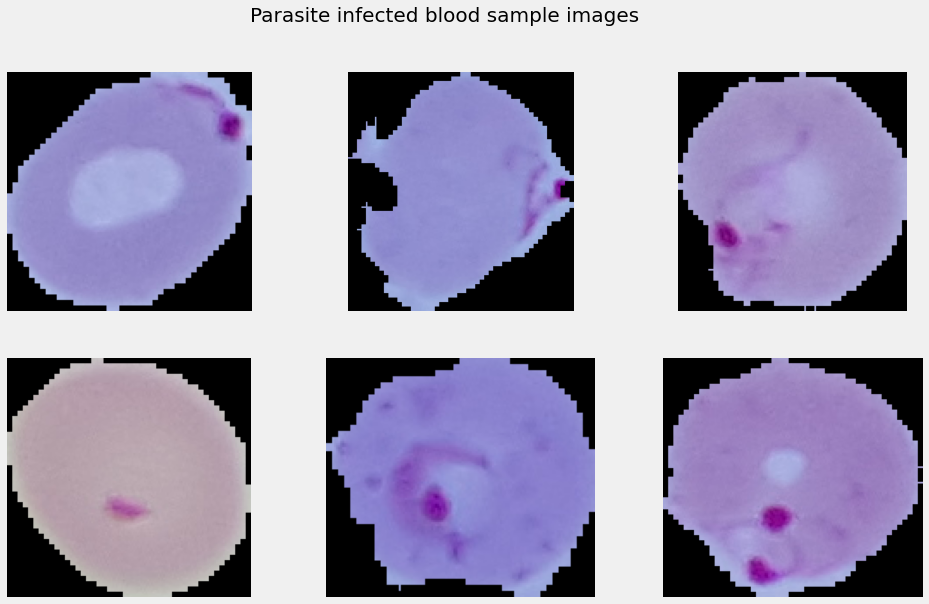

In [3]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Parasitized/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasite infected blood sample images',fontsize=20)
plt.show()

**Observation:**
- As we can see from above images that in infected sample there is small dot in almost every image which may be the critical mark while recognizing the imfected image. the model has to learn this pattern during training stage.

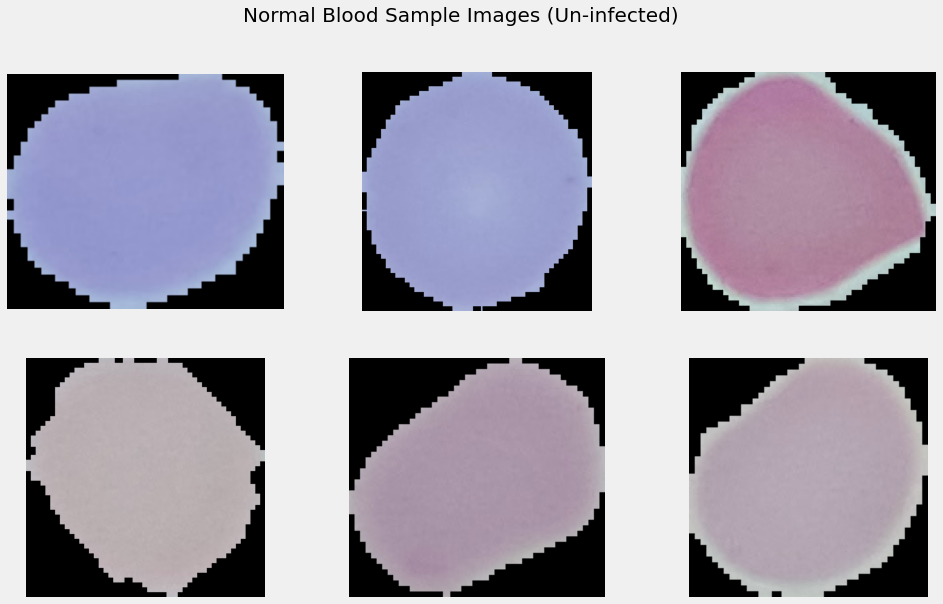

In [4]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Blood Sample Images (Un-infected)', fontsize=20)
plt.show()

**Observation:**
- As we can see normal images are clear with no mark to show.

## Step 4: Data Preprocessing (Labeling & Resizing of images)<a id='step-4'></a>

In [5]:
data=[]
labels=[]
Parasitized=os.listdir("cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [6]:
# segregating data and labels
Cells=np.array(data)
labels=np.array(labels)

np.save("Cells",Cells)
np.save("labels",labels)

In [7]:
# loading data of cell images and labels of images
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [8]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

num_classes=len(np.unique(labels))
len_data=len(Cells)

## Step 5: Train- Test Split<a id='step-5'></a>

In [9]:
# splitting cells images into 90:10 ratio i.e., 90% for training and 10% for testing purpose
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]

(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

## Step 6: Normalizing Data<a id='step-6'></a>

In [10]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

## Step 7: Label Encoding<a id='step-7'></a>

In [11]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

## Step 8: Model Building: CNN<a id='step-8'></a>

In [12]:
# Set random seed
np.random.seed(42)

#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0

## Step 9: Compiling the model<a id='step-9'></a>

In [13]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Step 10: Setting Callbacks<a id='step-10'></a>

In [14]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

## Step 11: Model Fitting<a id='step-11'></a>

In [15]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
h=model.fit(x_train,y_train,batch_size=128, validation_data=(x_test,y_test),epochs=500,verbose=1)

Epoch 1/500
194/194 [==============================] - 24s 122ms/step - loss: 0.6610 - accuracy: 0.5951 - val_loss: 0.5736 - val_accuracy: 0.8011
Epoch 2/500
194/194 [==============================] - 23s 121ms/step - loss: 0.3381 - accuracy: 0.8682 - val_loss: 0.1684 - val_accuracy: 0.9459
Epoch 3/500
194/194 [==============================] - 23s 117ms/step - loss: 0.2056 - accuracy: 0.9271 - val_loss: 0.1607 - val_accuracy: 0.9550
Epoch 4/500
194/194 [==============================] - 23s 119ms/step - loss: 0.1926 - accuracy: 0.9344 - val_loss: 0.1512 - val_accuracy: 0.9539
Epoch 5/500
194/194 [==============================] - 25s 127ms/step - loss: 0.1819 - accuracy: 0.9406 - val_loss: 0.1507 - val_accuracy: 0.9525
Epoch 6/500
194/194 [==============================] - 24s 122ms/step - loss: 0.1776 - accuracy: 0.9430 - val_loss: 0.1406 - val_accuracy: 0.9586
Epoch 7/500
194/194 [==============================] - 24s 124ms/step - loss: 0.1728 - accuracy: 0.9467 - val_loss: 0.1420 -

Epoch 57/500
194/194 [==============================] - 22s 114ms/step - loss: 0.1065 - accuracy: 0.9617 - val_loss: 0.1125 - val_accuracy: 0.9666
Epoch 58/500
194/194 [==============================] - 22s 114ms/step - loss: 0.1068 - accuracy: 0.9625 - val_loss: 0.1162 - val_accuracy: 0.9670
Epoch 59/500
194/194 [==============================] - 22s 114ms/step - loss: 0.1073 - accuracy: 0.9615 - val_loss: 0.1096 - val_accuracy: 0.9677
Epoch 60/500
194/194 [==============================] - 22s 113ms/step - loss: 0.1056 - accuracy: 0.9636 - val_loss: 0.1115 - val_accuracy: 0.9648
Epoch 61/500
194/194 [==============================] - 22s 113ms/step - loss: 0.1039 - accuracy: 0.9641 - val_loss: 0.1083 - val_accuracy: 0.9673
Epoch 62/500
194/194 [==============================] - 22s 113ms/step - loss: 0.1031 - accuracy: 0.9642 - val_loss: 0.1116 - val_accuracy: 0.9670
Epoch 63/500
194/194 [==============================] - 22s 113ms/step - loss: 0.1043 - accuracy: 0.9632 - val_loss: 0

194/194 [==============================] - 23s 118ms/step - loss: 0.0672 - accuracy: 0.9781 - val_loss: 0.1352 - val_accuracy: 0.9644
Epoch 168/500
194/194 [==============================] - 23s 117ms/step - loss: 0.0662 - accuracy: 0.9779 - val_loss: 0.1393 - val_accuracy: 0.9633
Epoch 169/500
194/194 [==============================] - 23s 120ms/step - loss: 0.0662 - accuracy: 0.9779 - val_loss: 0.1403 - val_accuracy: 0.9648
Epoch 170/500
194/194 [==============================] - 23s 118ms/step - loss: 0.0655 - accuracy: 0.9781 - val_loss: 0.1319 - val_accuracy: 0.9659
Epoch 171/500
194/194 [==============================] - 23s 117ms/step - loss: 0.0646 - accuracy: 0.9786 - val_loss: 0.1403 - val_accuracy: 0.9652
Epoch 172/500
194/194 [==============================] - 23s 117ms/step - loss: 0.0688 - accuracy: 0.9762 - val_loss: 0.1384 - val_accuracy: 0.9637
Epoch 173/500
194/194 [==============================] - 23s 117ms/step - loss: 0.0614 - accuracy: 0.9788 - val_loss: 0.1488 -

194/194 [==============================] - 23s 119ms/step - loss: 0.0472 - accuracy: 0.9838 - val_loss: 0.1741 - val_accuracy: 0.9604
Epoch 278/500
194/194 [==============================] - 23s 118ms/step - loss: 0.0467 - accuracy: 0.9846 - val_loss: 0.1606 - val_accuracy: 0.9623
Epoch 279/500
194/194 [==============================] - 25s 130ms/step - loss: 0.0465 - accuracy: 0.9842 - val_loss: 0.1647 - val_accuracy: 0.9637
Epoch 280/500
194/194 [==============================] - 26s 133ms/step - loss: 0.0478 - accuracy: 0.9829 - val_loss: 0.1728 - val_accuracy: 0.9615
Epoch 281/500
194/194 [==============================] - 25s 127ms/step - loss: 0.0541 - accuracy: 0.9836 - val_loss: 0.1566 - val_accuracy: 0.9633
Epoch 282/500
194/194 [==============================] - 23s 120ms/step - loss: 0.0480 - accuracy: 0.9839 - val_loss: 0.1644 - val_accuracy: 0.9597
Epoch 283/500
194/194 [==============================] - 24s 123ms/step - loss: 0.0491 - accuracy: 0.9840 - val_loss: 0.1637 -

194/194 [==============================] - 24s 123ms/step - loss: 0.0433 - accuracy: 0.9865 - val_loss: 0.1706 - val_accuracy: 0.9590
Epoch 388/500
194/194 [==============================] - 24s 124ms/step - loss: 0.0393 - accuracy: 0.9880 - val_loss: 0.1911 - val_accuracy: 0.9575
Epoch 389/500
194/194 [==============================] - 24s 124ms/step - loss: 0.0413 - accuracy: 0.9857 - val_loss: 0.1764 - val_accuracy: 0.9604
Epoch 390/500
194/194 [==============================] - 23s 120ms/step - loss: 0.0479 - accuracy: 0.9850 - val_loss: 0.1667 - val_accuracy: 0.9597
Epoch 391/500
194/194 [==============================] - 23s 120ms/step - loss: 0.0393 - accuracy: 0.9875 - val_loss: 0.1701 - val_accuracy: 0.9619
Epoch 392/500
194/194 [==============================] - 24s 122ms/step - loss: 0.0362 - accuracy: 0.9879 - val_loss: 0.1737 - val_accuracy: 0.9604
Epoch 393/500
194/194 [==============================] - 24s 124ms/step - loss: 0.0383 - accuracy: 0.9873 - val_loss: 0.1677 -

194/194 [==============================] - 24s 123ms/step - loss: 0.0374 - accuracy: 0.9875 - val_loss: 0.1722 - val_accuracy: 0.9568
Epoch 498/500
194/194 [==============================] - 24s 123ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.1627 - val_accuracy: 0.9615
Epoch 499/500
194/194 [==============================] - 24s 124ms/step - loss: 0.0382 - accuracy: 0.9873 - val_loss: 0.1771 - val_accuracy: 0.9572
Epoch 500/500
194/194 [==============================] - 24s 124ms/step - loss: 0.0381 - accuracy: 0.9883 - val_loss: 0.1835 - val_accuracy: 0.9550


## Step 12: Model Evaluation<a id='step-12'></a>

In [16]:
# saving the weight of model
from numpy import loadtxt
from keras.models import load_model
model = load_model('.mdl_wts.hdf5')

#checking the score of the model
score=model.evaluate(x_test,y_test)
print(score)

87/87 [==============================] - 1s 9ms/step - loss: 0.1122 - accuracy: 0.9662
[0.11223597824573517, 0.9662432074546814]


In [17]:
# checking the accuracy of thr 
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

87/87 [==============================] - 1s 9ms/step - loss: 0.1122 - accuracy: 0.9662

 Test_Accuracy:- 0.9662432074546814


### Confusion Matrix

87/87 [==============================] - 1s 8ms/step


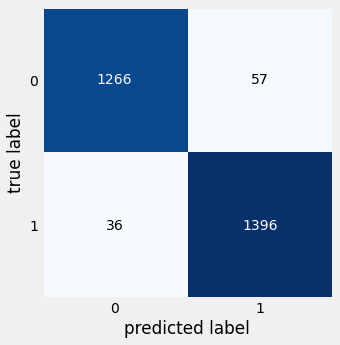

In [18]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

#creating confusion matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### Plotting History of Model's Accuracy 

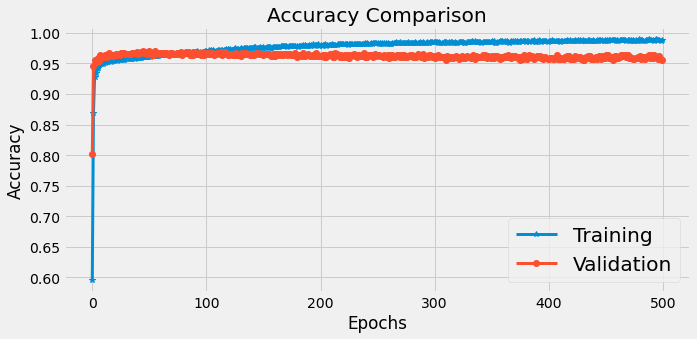

In [19]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'Training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'Validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    




visualize_training(h)


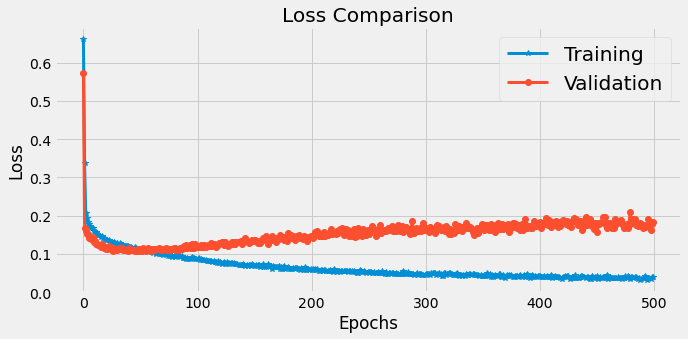

In [20]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'Training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'Validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()


visualize_training(h)

### Printing Classification report

In [21]:
print('{}'.format( 
                           classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1323
           1       0.96      0.97      0.97      1432

    accuracy                           0.97      2755
   macro avg       0.97      0.97      0.97      2755
weighted avg       0.97      0.97      0.97      2755



## Step 13: Plotting ROC AUC Curve<a id='step-13'></a>
In this step we will first compute Are Under Curve (AUC) based on which we plot ROC curve

### Computing Area Under Curve (AUC)

In [22]:
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9658882174843868

In [23]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

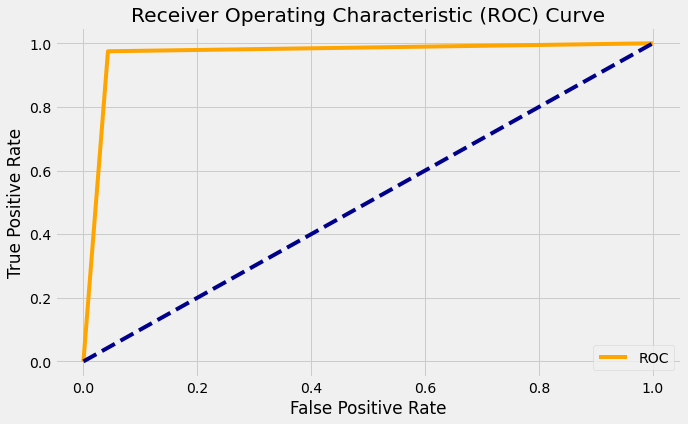

In [24]:
plot_roc_curve(fpr_keras, tpr_keras)

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, color='orange', label='Sequential CNN (AUROC = %0.3f)' % auc_keras)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
plot_roc_curve(fpr_keras, tpr_keras)

## Step 14: Plotting Sample Prediction (Groundtruth vs Predicted)<a id='step-14'></a>
In this step we will test our model by plotting 12 random prediction in which ground truth is in brackets and predicted value is outside the bracket if both match then the color will be blue whereas incorrect or misclassified instances will show in orange color.

In [25]:
y_hat = model.predict(x_test)

# define text labels 
malaria_labels = ['Parasitized','Uninfected']

87/87 [==============================] - 1s 9ms/step


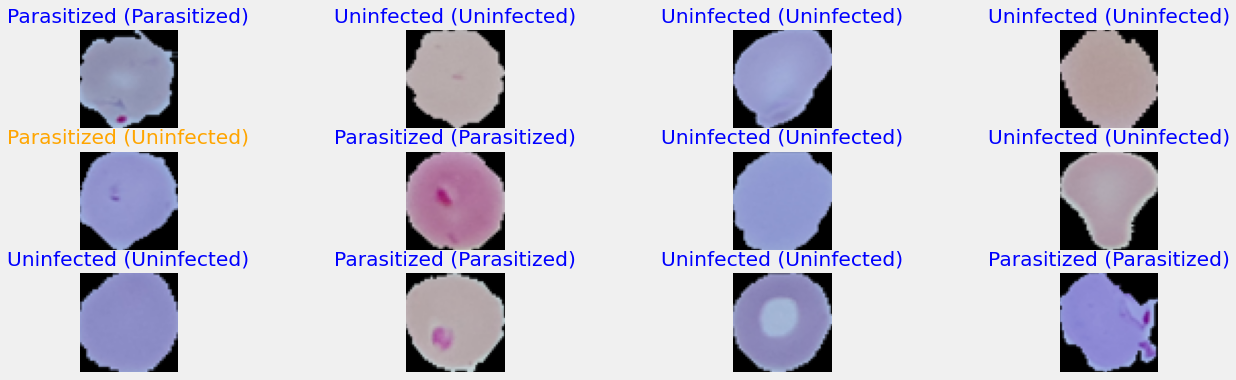

In [26]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

## Conclusion & Future Improvements <a id='conc-fut'></a>

- As we have seen our model is giving approx 96% recall and auc of around 96.36 which is good overall.
- Further, we can also do data augmentation to increase the dataset and improve the accuracy
- The only misclassified instance shown in our random sample plotting has seems to have a small mark but in real its not which our model errorneously understand as a mark and therefore predicted as infected sample.
- I have deployed this model as a web app where we can upload the blood sample image and the model will predict status of sample whether it is infected or normal.